You can model cascade flows for turbomachinery in viiflow by defining additional geometric quantities.

<img src="Nomenclature.png" alt="Nomenclature" style="width: 700px;"/>

In [1]:
%matplotlib inline
import viiflow as vf
import viiflowtools.vf_tools as vft
import viiflowtools.vf_plots as vfp
import numpy as np
from numpy import *
import matplotlib
import matplotlib.pyplot as plt

%config InlineBackend.figure_format = 'svg'
import logging
logging.getLogger().setLevel(logging.WARNING)
ratio = [12, 6]
matplotlib.rcParams['figure.figsize'] = ratio


## Gostelow analytic solution
In [1] the theoretical pressure distribution is calculated using a complex transformation method.
This data is used in the following to compare the inviscid solution.
To that end, we first generate the airfoil as (more or less) described in [1].

<ipython-input-2-e76c3020834e>:16: RuntimeWarning: invalid value encountered in arccosh
  mc = 0.5*arccosh(cos(2*nc)+sinh(betaDash)**2*sin(2*nc)/nc)


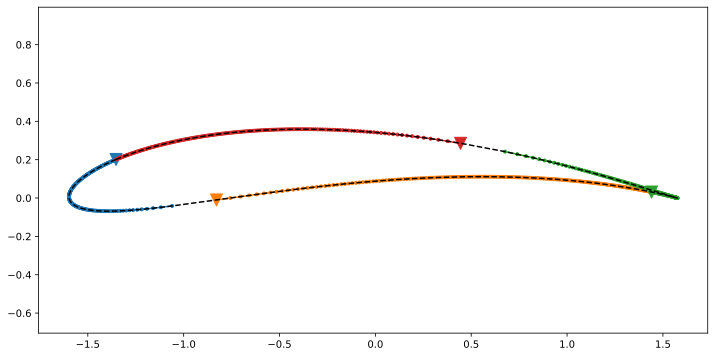

In [2]:
def coth(x):
    return cosh(x)/sinh(x)

def sech(x):
    return 1.0/cosh(x)

# Airfoil from oval
n = -0.0632
m = 0.112512215
delta = 37.5*pi/180
betaDash = 0.8
beta = 0.725

NC = 200
nc = r_[np.linspace(1e-12,(1-1e-12)*betaDash,NC)]
mc = 0.5*arccosh(cos(2*nc)+sinh(betaDash)**2*sin(2*nc)/nc)

lQ1 = (mc+m)+(nc+n)*1j
lQ2 = (-mc[::-1]+m)+(nc[::-1]+n)*1j
lQ3 = (-mc+m)+(-nc+n)*1j
lQ4 = (mc[::-1]+m)+(-nc[::-1]+n)*1j


def contour(l,beta,signum):
    gamma = beta+sinh(beta)**2*coth(beta)
    lam = l + sinh(beta)**2*coth(l)
    cosf = cosh(lam)/cosh(gamma)
    Z = (lam*cos(delta) - signum*1j*sin(delta)*arccosh(cosf))
    return Z

colors = ['C0','C1','C2','C3']
fig, ax = plt.subplots()
k=0
for l in [lQ1,lQ2,lQ3,lQ4]:
    l = l[~isnan(l)]
    k+=1
    Z = contour(l,beta,1)
    Z2 = contour(l,beta,-1)
    if k==3:
        gamma = beta+sinh(beta)**2*coth(beta)
        lam = l + sinh(beta)**2*coth(l)
        cosf = cosh(lam)/cosh(gamma)
        Index = (imag(cosf)>0)
        Z0 = Z.copy()
        Z[Index] = Z2[Index]
        Z[-1] = Z0[-1]
    ax.plot(-real(Z[0]),-imag(Z[0]),'v',color=colors[k-1],markersize=12)
    ax.plot(-real(Z),-imag(Z),'.-')
    if k==1:
        X = c_[-real(Z),-imag(Z)]
    else:
        X = r_[X,c_[-real(Z),-imag(Z)]]
ax.axis('equal');
X=X.T
ax.plot(X[0,:],X[1,:],'--k')

(-0.5, 788.5, 775.5, -0.5)

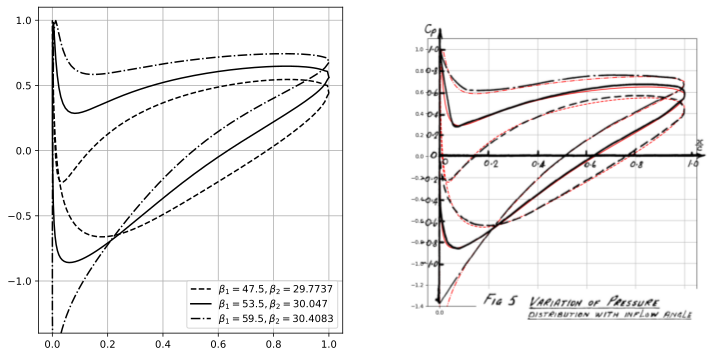

In [3]:
# Reorder above paneling
# Find maximum element
imax = argmax(X[0,:])
# Resort
XN = c_[X[:,imax::],X[:,0:imax+1]]

# Scale and shift
maxv = max(XN[0,:])
minv = min(XN[0,:])
XN[0,:]-=minv
XN = XN/(maxv-minv)

# Repanel
XN = vft.repanel(XN,160)

# Cascade Parameters
beta = 37.5 # Stagger Angle
h = 0.990157


# plot inviscid solution at different AOA
fig, ax = plt.subplots(1,2)

lines = ["--k","-k","-.k"]
k=0
for beta1 in [47.5,53.5,59.5]:
    # Setup
    s = vf.setup(Re=1e6,Ma=0,Ncrit=9,Alpha=beta1-beta,IterateWakes=False,IsCascade=True,CascadeStaggerHeight=h,CascadeStaggerAngle=beta)
    
    # Solve inviscid (and initialize unused boundary layer)
    [p,bl,x] = vf.init([XN],s)
    ax[0].plot(XN[0,:],1-power(p.gamma_inviscid,2),lines[k],label=r"$\beta_1=%g,\beta_2=%g$"%(beta1,beta1-p.CascadeDeflectionAngleInviscid))
    k+=1

plt.yticks(np.arange(-1.4, 1.2, 0.2))

ax[0].set_ylim((-1.4,1.1))
#ax.set_xlim((-0.1,1.1))
ax[0].grid(which='both')
ax[0].legend()

ax[1].imshow(plt.imread("Gostelow.png"))
plt.axis('off')

On the right you see the same plot, photoshopped into a scan of the original document. Note that the axes were a bit skewed, and the lower and upper graph parts were scaled a bit differently to align the y-ticks.
There is some difference in these comparisons, in that all analytical solutions seem to have their stagnation point at exactly 0, the sharp kink in the solid graph is not seen in the calculations and some overall difference which may or may not also be due to issues with the scan or the method of drawing the original lines based on some sample points. The outlet angles $\beta_2$ from Gostelow seem to be 29.5°, 30° and 30.25°.

## NACA 65XX10 data
In [3] a whole lot of pressure and deflection angle data have been assembled and also used e.g. for similar purposes in [4]. I chose to use the same data for comparison as in [4].

In [4]:
# The code below can be found in the appendix of [2] which I copied (including the comments you see there) and 
# modified to be usable here.
def get_naca65xx10(N,CL):
    # NACA 65 SERIES TANDEM AIRFOIL GENERATOR

    # Data available for NACA 650010 ( a =1.0) L .E radius =0.687 percent c
    # Ref : Abbott , I. H., and von Doenhoff , A. E ., 1959 , " Theory of Wing
    # Sections ", Dover Publications . pp . 111 -123 , 362 , 405.
    x1 = linspace (10 ,100 ,19); # part of the abscissa which are linearly spaced
    x = r_[asarray([0, 0.5, 0.75, 1.25, 2.5 ,5.0 ,7.5]), x1 ];
    #x coordinates ( percent chord ) of mean camber line in percent chord length
    yc = asarray([0, 0.250, 0.350, 0.535, 0.930, 1.580, 2.120, 2.585, 3.365, 3.980,
    4.475, 4.860, 5.150, 5.355, 5.475, 5.515, 5.475, 5.355, 5.150,
    4.860, 4.475, 3.980 ,3.365 ,2.585 ,1.580, 0]);
    # ordinates ( percent chord ) of mean camber line in percent chord length
    yt =asarray([0, 0.772, 0.932, 1.169, 1.574 ,2.177, 2.647 ,3.040, 3.666,
    4.143, 4.503, 4.760 ,4.924 ,4.996, 4.963, 4.812 ,4.530 ,4.146,
    3.682, 3.156, 2.584, 1.987, 1.385, 0.810, 0.306, 0]);
    # thickness in ( percent chord ) distribution
    m = asarray([0, 0.4212 ,0.38875, 0.3477 ,0.29155, 0.2343, 0.19995, 0.17485, 0.13805,
    0.1103, 0.08745, 0.06745, 0.04925, 0.03225, 0.01595, 0 ,-0.01595, -0.03225,
    -0.04925, -0.06745, -0.08745, -0.1103 ,-0.13805, -0.17485 ,-0.2343, 0]);
    # slope at each x locations
    theta = arctan (m );
    # angle at each coordinate before scaling
    # Front Blade
    ch_fb = 1000 # Chord in mm
    x_fb = ch_fb *( x /100); # scales the abscissa for the required chord length
    yc_fb = ch_fb *( yc /100); # scales the mean camber line for the required
    # chord length  
    yt_fb = ch_fb *( yt /100); # scales the thickness distribution for the
    # required chord length

    xu_fb = x_fb - yt_fb * sin ( theta ); # x coordinate of upper profile
    yu_fb = yc_fb + yt_fb * cos ( theta ); #y coordinate of upper profile
    xl_fb = x_fb + yt_fb * sin ( theta ); # x coordinate of lower profile
    yl_fb = yc_fb - yt_fb * cos ( theta ); #y coordinate of lower profile

    s_fb = CL #input (’ Enter the scaling factor for mean camber line of front blade : ’);
    yc_new_fb = s_fb * yc_fb ; # scales mean camber line
    m_new_fb = s_fb * m; # scales the slope
    theta_new_fb = arctan ( m_new_fb ); # angle at each x coordinate after scaling
    # front blade
    xu_new_fb = x_fb - yt_fb * sin ( theta_new_fb ); #x coordinate of upper profile
    yu_new_fb = yc_new_fb + yt_fb * cos ( theta_new_fb ); #y coordinate of upper profile
    xl_new_fb = x_fb + yt_fb * sin ( theta_new_fb ); #x coordinate of lower profile
    yl_new_fb = yc_new_fb - yt_fb * cos ( theta_new_fb ); #y coordinate of lower profile


    X = zeros((2,len(xu_new_fb)*2-1))
    X[0,:] = r_[xu_new_fb[::-1],xl_new_fb[1::]]/1000
    X[1,:] = r_[yu_new_fb[::-1],yl_new_fb[1::]]/1000
    XF = vft.repanel(X,N)
    minX = min(XF[0,:])
    maxX = max(XF[0,:])
    XF[0,:]-=minX
    XF[0,:]/(maxX-minX)
    return XF




Iteration 21, |res| 0.000073, lam 0.500000
Iteration 21, |res| 0.000088, lam 0.500893
Iteration 22, |res| 0.000063, lam 0.500000
Iteration 14, |res| 0.000021, lam 1.000000
Iteration 13, |res| 0.000015, lam 1.000000
Iteration 16, |res| 0.000067, lam 0.500000
Iteration 12, |res| 0.000072, lam 0.500000
Iteration 12, |res| 0.000081, lam 1.000000
Iteration 13, |res| 0.000055, lam 1.000000
Iteration 11, |res| 0.000029, lam 1.000000
Iteration 7, |res| 0.000029, lam 1.000000
Iteration 22, |res| 0.000051, lam 0.652533


(<panelCpl.panel_problem.PanelProblem at 0x180bff4ae10>,
 array([<ibl.ibl_classes.bl_airfoil object at 0x00000180C13364A0>],
       dtype=object))

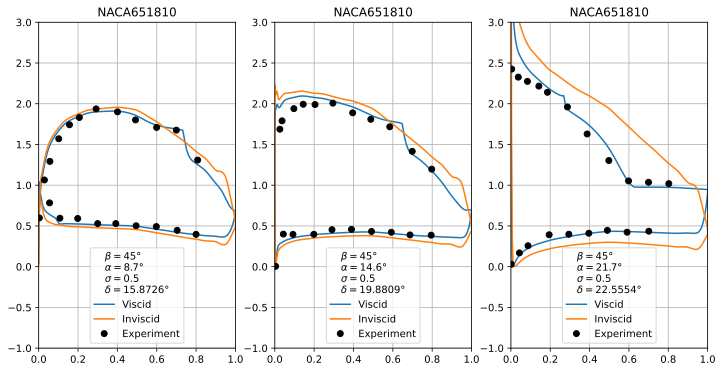

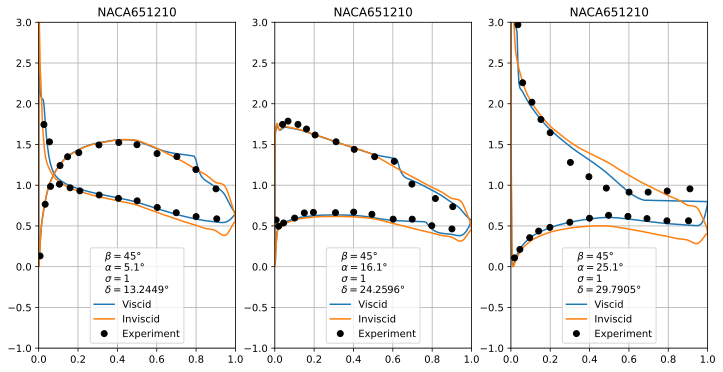

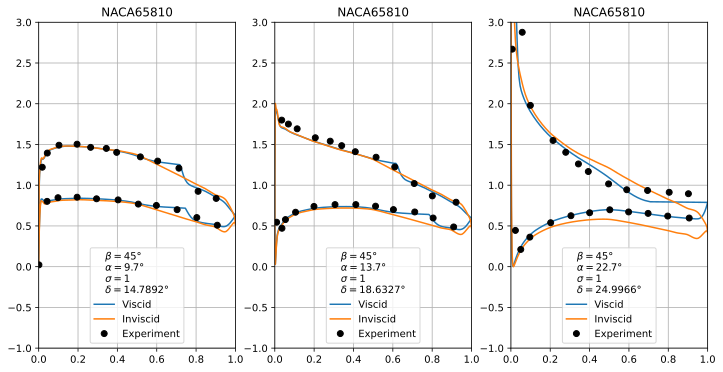

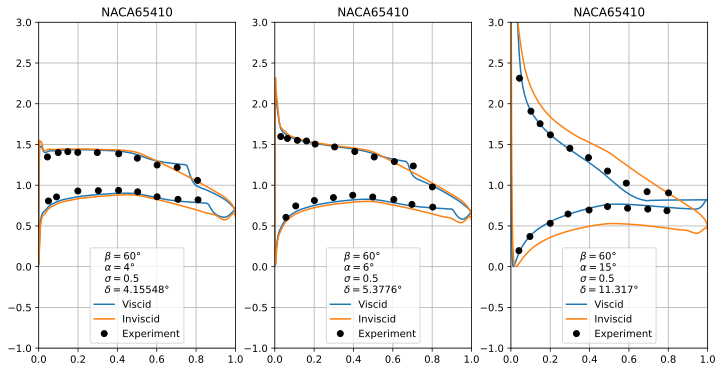

In [73]:
def run_NACA65xx10(CL,beta_1,alpha_1,h,ax):
    XF = get_naca65xx10(240,CL)
    EXPRES=np.genfromtxt("NACAData2.csv",delimiter=";",skip_header=1,dtype='f8',names=True)
    # Setup
    s = vf.setup(Re=354000,Ma=0.0,Ncrit=9,IsCascade=True)
    s.IterateWakes=True # While this is not necessary for good enough cp results, without it the wake is not aligned with the viscous deflection angle
    s.WakeLength=2 # For cascade flows, it seems a good idea to have longer wakes
    beta = beta_1-alpha_1 # Stagger Angle
    # Setup
    s.Alpha = alpha_1
    s.CascadeStaggerAngle=beta
    s.CascadeStaggerHeight=h
    #Solve inviscid (and initialize unused boundary layer)
    [p,bl,x] = vf.init([XF],s)
    [x,flag,_,_,_] = vf.iter(x,bl,p,s)
    if not ax is None:
        ax.plot(p.foils[0].X[0,:],power((p.gamma_viscid[0:XF.shape[1]]),2),label="Viscid")
        ax.plot(p.foils[0].X[0,:],power((p.gamma_inviscid[0:XF.shape[1]]),2),label="Inviscid")
        ax.plot(EXPRES["X%u_%u"%(int(CL*10),floor(alpha_1))],EXPRES["Y%u_%u"%(int(CL*10),floor(alpha_1))],'ok',label="Experiment")
        titlestr = r"$\beta=%g°$"%beta_1+"\n"+r"$\alpha=%g°$"%alpha_1+"\n"+r"$\sigma=%g$"%(1.0/h)+"\n"+r"$\delta=%g°$"%p.CascadeDeflectionAngle
        ax.legend(loc="lower center",title=titlestr)   
        ax.grid("on")
        ax.set_xticks(np.arange(-0.0, 1.1, 0.2))
        ax.set_xlim([0,1])
        ax.set_ylim([-1,3])
        ax.set_title("NACA65%u10"%int(10*CL))
    return (p,bl)

fig, ax = plt.subplots(1,3)
run_NACA65xx10(1.8,45,8.7,2,ax[0])
run_NACA65xx10(1.8,45,14.6,2,ax[1])
run_NACA65xx10(1.8,45,21.7,2,ax[2])

fig, ax = plt.subplots(1,3)
run_NACA65xx10(1.2,45,5.1,1,ax[0])
(p,bl) = run_NACA65xx10(1.2,45,16.1,1,ax[1]) # Save that for another plot below
run_NACA65xx10(1.2,45,25.1,1,ax[2])
    
fig, ax = plt.subplots(1,3)
run_NACA65xx10(.8,45,9.7,1,ax[0])
run_NACA65xx10(.8,45,13.7,1,ax[1])
run_NACA65xx10(.8,45,22.7,1,ax[2])
    
fig, ax = plt.subplots(1,3)
run_NACA65xx10(.4,60,4.0,2,ax[0])
run_NACA65xx10(.4,60,6.0,2,ax[1])
run_NACA65xx10(.4,60,15.0,2,ax[2])
    

For a variety of solidities and camber profiles, the agreement in pressure distribution is excellent for low and mediaum angles of attack, while at high angles of attack the results differ.

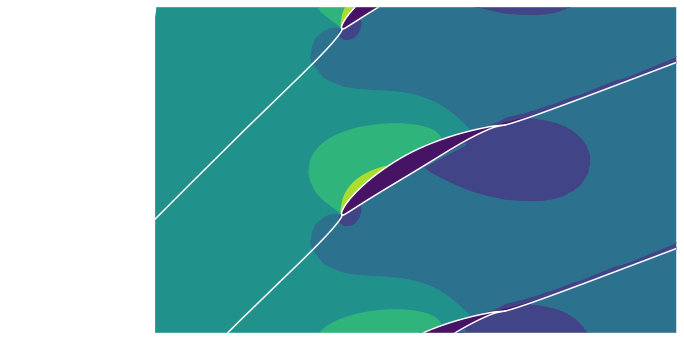

In [75]:
# This plot is a modification of the plot used in the Visualization notebook
# In addition, it 
# * Rotates the plot by the stagger angle (such that the stagger axis is vertical)
# * Adds a streamline from the stagation point upstream
# * Puts two mirror images of the plot on top/bottom
def plot_flowfield(p,bl):

    def rotate(deg,center,x):
        c, s = np.cos(deg*np.pi/180), np.sin(deg*np.pi/180)
        A = np.array([[c, s], [-s, c]])
        #center = center@np.ones((1,x.shape[1]))
        return ((A@((x.T-center.T).T)).T+center.T).T
    center = np.r_[0.0,0.0]

    coss = np.cos((-p.CascadeStaggerAngle)*pi/180)
    sins = np.sin((-p.CascadeStaggerAngle)*pi/180)

    Nbl = 10 # Num. of normal elements in boundary layer
    Nin = 40 # Num. of normal inviscid elements beyond the boundary layer
    hy = 1 # Distance from the airfoil and wake up to which the field is calculated
    [x,y,UI,VI] = vfp.total_flowfield(p,bl,Nbl,Nin,hy)
    fig,ax = plt.subplots(1,1)
    xdata = x.ravel()*coss+sins*y.ravel()
    ydata = x.ravel()*-sins+coss*y.ravel()
    vdata = (UI**2+VI**2).ravel()
    # Add on top/below
    xdata = r_[xdata,xdata,xdata]
    ydata = r_[ydata,ydata-p.CascadeStaggerHeight,ydata+p.CascadeStaggerHeight]
    vdata = r_[vdata,vdata,vdata]
    
    CS=ax.tricontourf(xdata,ydata,vdata,levels=[0,.2,.6,.9,1.1,1.5,2])
    ax.axis('equal')
    XFoil = rotate(-p.CascadeStaggerAngle,center,p.foils[0].X)
    XWake = rotate(-p.CascadeStaggerAngle,center,p.wakes[0].X)

    
    xlims = (-1.75,1.75)
    dy = 0.5*sin(p.CascadeStaggerAngle*pi/180) # Assuming chord=1, shift center by this
    ylims = (-(xlims[1]-xlims[0])*ratio[1]/ratio[0]/2+dy,(xlims[1]-xlims[0])*ratio[1]/ratio[0]/2+dy)
    ax.set(xlim=xlims,ylim=ylims);


    # This is a modification so that nice svgs are plotted
    # See https://github.com/matplotlib/matplotlib/issues/4419
    for a in CS.collections:
        a.set_edgecolor('face')
    ax.axis('off');

    # Integrate upstream from stagnation point
    N = 20 # Num. of streamline elements
    x = np.zeros((2,N))
    sti = bl[0].sti # Index of closest node to stagnation
    x[0,0] = p.foils[0].X[0,sti]-1e-5
    x[1,0] = p.foils[0].X[1,sti]
    v = np.zeros((2,1)) # Velocity buffer
    stepsize = 2e-3 #increase each step 
    for k in range(1,N):
        vf.inviscid_velocity(p,x[:,k-1:k],v[:,0:1])
        # Normalize for streamline integration
        v/=np.sqrt(v[0]**2+v[1]**2)
        # Tiny step forward
        x[:,k] = x[:,k-1] - v[:,0]*stepsize
        stepsize*=1.5

    x = rotate(-p.CascadeStaggerAngle,center,x)

    for k in [-1,0,1]:
        ax.plot(XFoil[0,:],XFoil[1,:]+p.CascadeStaggerHeight*k,'-w')
        ax.plot(XWake[0,:],XWake[1,:]+p.CascadeStaggerHeight*k,'-w')
        ax.plot(x[0,:],x[1,:]+p.CascadeStaggerHeight*k,'-w')
        
plot_flowfield(p,bl)

[1] Gostelow, J. P. *Potential flow through cascades: a comparison between exact and approximate solutions.* HM Stationery Office, 1965.

[2] Manas, MP. *Numerical studies on tandem compressor cascades.* Indian Institute of Space Science and Technology, 2015. (Master Thesis)

[3] Herrig, L. Joseph, James C. Emery, and John R. Erwin. *Systematic two-dimensional cascade tests of NACA 65-series compressor blades at low speeds.* (1957). NACA TN 3916 

[4] Ramirez Camacho, R. G., and Nelson Manzanares Filho. *A source wake model for cascades of axial flow turbomachines.* Journal of the Brazilian Society of Mechanical Sciences and Engineering 27.3 (2005): 288-299.